# Prototype Notebook for Recipe Popularity Prediction

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

C:\Users\kurze\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Load data
df = pd.read_csv('Data/full_dataset.csv')
# df_ingredients_instructions = pd.read_json('Data/ingredient_and_instructions.json').T
# df_merge = pd.concat([df, df_ingredients_instructions.reset_index(drop=True)], axis=1, join='outer')

In [4]:
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


The dataset contains information about various recipes, including attributes such as country, description, keywords, language, name, slug, video URL, total time, and nutritional values.

## 2. Visualize the data

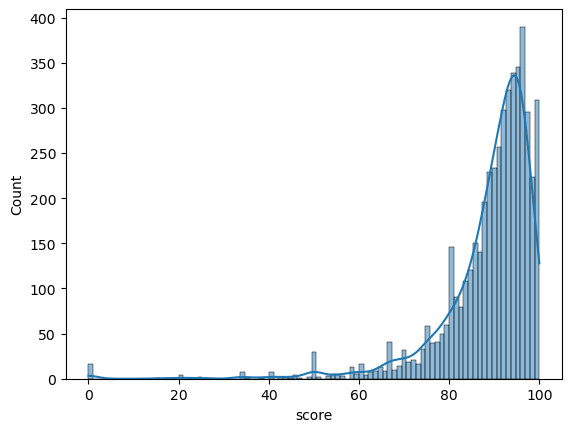

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['score'], kde=True)
plt.show()

### Interpretation of the Histogram for Recipe Scores

The histogram with a Kernel Density Estimate (KDE) overlay provides a visual representation of the distribution of the `score` variable in the dataset.

1. **Distribution Shape:**
   - The histogram shows a skewed distribution, with a majority of the scores clustering towards the higher end (80 to 100).
   - The KDE curve smooths out the distribution and further highlights this skewness, showing a steep increase as the scores approach 100.

2. **Concentration of High Scores:**
   - There is a significant concentration of recipes with scores between 80 and 100. This suggests that most recipes in the dataset are highly rated.
   - The peak at around 90-100 indicates that many recipes are given nearly perfect scores, which could reflect a general tendency towards positive ratings or a bias in the rating system.

## 3. Data preparation and cleaning

### Removing columns

Drop Unnecessary Columns: Drop the columns description, video_url, inspired_by, and linked_recipes.

In [5]:
# Step 1: Drop columns with too many missing values and not needed for analysis
columns_to_drop = ['description', 'video_url', 'thumbnail_url', 'country', 'id_', 'language', 'inspired_by', 'linked_recipes', 'Unnamed: 0', 'is_licensed_video', 'slug', 'tags']
df_merge.drop(columns=columns_to_drop, inplace=True)

### Flatten ingredients and instructions lists

In [6]:
# Extract and flatten ingredients and instructions, and count them
def flatten_ingredients_and_count(ingredients_list):
    if isinstance(ingredients_list, list):
        flattened = []
        count = 0
        for category in ingredients_list:
            if 'ingredients' in category:
                for ingredient in category['ingredients']:
                    primary_unit = ingredient.get('primary_unit') or {}
                    quantity = primary_unit.get('quantity', '')
                    unit = primary_unit.get('display', '')
                    name = ingredient.get('name', '')
                    extra_comment = ingredient.get('extra_comment', '')
                    parts = [quantity, unit, name, extra_comment]
                    parts = [part for part in parts if part]  # Remove empty strings
                    flattened.append(' '.join(parts))
                    count += 1
        return '; '.join(flattened), count
    return '', 0

def flatten_instructions_and_count(instructions_list):
    if isinstance(instructions_list, list):
        steps = [instruction['display_text'] for instruction in instructions_list]
        return ' '.join(steps), len(steps)
    return '', 0

In [7]:
# Apply the functions to create new columns
df_merge['flattened_ingredients'], df_merge['num_ingredients'] = zip(*df_merge['ingredient_sections'].apply(flatten_ingredients_and_count))
df_merge['flattened_instructions'], df_merge['num_steps'] = zip(*df_merge['instructions'].apply(flatten_instructions_and_count))

In [8]:
# Set display options to show full instructions
pd.set_option('display.max_colwidth', None)

# Check the resulting DataFrame
print(df_merge[['flattened_ingredients', 'flattened_instructions']].head())
df_merge.drop(columns=['ingredient_sections', 'instructions'], inplace=True)

                                                                                                                                                                                                                                                                                                                                                                                                                                            flattened_ingredients  \
0                                                 ½ cup unsalted butter melted; 2 cups whole milk warm to the touch; ½ cup granulated sugar; 2 ¼ teaspoons active dry yeast; 5 cups flour divided; 1 teaspoon baking powder; 2 teaspoons salt; ¾ cup butter softened; ¾ cup light brown sugar; 2 tablespoons ground cinnamon; 4 oz cream cheese softened; 2 tablespoons butter melted; 2 tablespoons whole milk; 1 teaspoon vanilla extract; 1 cup powdered sugar   
1                                                                                             

### Data vecotrization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Handle missing values for keywords
df_merge['keywords'].fillna('no_keywords', inplace=True)

# Create a copy of df_merge for numerical processing
df_numerical = df_merge.copy()

# List of text features to vectorize
text_features = ['name', 'flattened_ingredients', 'flattened_instructions', 'keywords']

# Initialize TF-IDF Vectorizers
vectorizers = {feature: TfidfVectorizer(max_features=20) for feature in text_features}

# Fit and transform the text features
for feature in text_features:
    tfidf_matrix = vectorizers[feature].fit_transform(df_numerical[feature].fillna('')).toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'{feature}_tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
    df_numerical = pd.concat([df_numerical, tfidf_df], axis=1)

# Drop original text columns from df_numerical
df_numerical.drop(columns=text_features, inplace=True)

In [10]:
# List of boolean features
boolean_features = ['is_shoppable', 'is_community']

In [11]:
# Convert boolean features to numeric
for feature in boolean_features:
    df_numerical[feature] = df_numerical[feature].astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB


In [13]:
df_numerical

,is_shoppable,is_community,cook_time,prep_time,total_time,ratings_negative,ratings_positive,score,protein,fat,...,keywords_tfidf_10,keywords_tfidf_11,keywords_tfidf_12,keywords_tfidf_13,keywords_tfidf_14,keywords_tfidf_15,keywords_tfidf_16,keywords_tfidf_17,keywords_tfidf_18,keywords_tfidf_19
0,1,0,30,30,151,475,17340,98.0,7.0,21.0,...,0.000000,0.45696,0.0,0.000000,0.0,0.403172,0.00000,0.251445,0.320146,0.000000
1,1,0,0,15,15,777,8483,92.0,0.0,0.0,...,0.000000,0.00000,0.0,0.239697,0.0,0.000000,0.78296,0.395359,0.000000,0.229007
2,1,0,20,10,35,1099,5009,83.0,36.0,50.0,...,0.680142,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.452804,0.576520,0.000000
3,1,0,30,25,190,207,6649,97.0,8.0,25.0,...,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.00000,0.843567,0.537024,0.000000
4,1,0,0,0,0,591,3853,87.0,7.0,4.0,...,0.000000,0.00000,0.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,1,1,0,0,0,0,0,NaN,NaN,NaN,...,0.000000,0.00000,0.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000
4957,1,1,0,0,0,0,0,NaN,NaN,NaN,...,0.000000,0.00000,0.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000
4958,1,1,0,0,0,0,0,NaN,6.0,7.0,...,0.000000,0.00000,0.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000
4959,1,1,0,0,0,0,0,NaN,40.0,25.0,...,0.000000,0.00000,0.0,0.000000,1.0,0.000000,0.00000,0.000000,0.000000,0.000000


### Handle Missing values

I will use a more advanced imputation method KNN imputation. This method uses the k-nearest neighbors to impute missing values based on the similarity of other feature values. The neighbors are the k most similar instances (rows) to the instance with the missing value.

In [14]:
from fancyimpute import KNN

# Function to apply KNN imputation
def knn_imputation(df, columns_with_zeros):
    # Replace zero values in the specified columns with NaN for imputation
    df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
    
    # Check for missing values before imputation
    missing_values_before = df[columns_with_zeros].isnull().sum()
    print("Missing values before imputation:\n", missing_values_before)

    # Check for zeros before imputation
    zero_values_before = (df[columns_with_zeros] == 0).sum()
    print("\nZero values before imputation:\n", zero_values_before)

    # Include all relevant features for imputation
    features_for_imputation = [col for col in df.columns if col not in columns_with_zeros]

    # Combine the columns to impute with features
    df_for_imputation = df[columns_with_zeros + features_for_imputation]

    # Apply KNN imputation
    df_imputed = pd.DataFrame(KNN(k=5).fit_transform(df_for_imputation), columns=columns_with_zeros + features_for_imputation)

    # Update the original DataFrame with imputed values
    df.update(df_imputed[columns_with_zeros])

    # Verify the changes
    print("\nMissing values after imputation:\n", df[columns_with_zeros].isnull().sum())
    print("\nZero values after imputation:\n", (df[columns_with_zeros] == 0).sum())

In [15]:
# Select the columns for KNN imputation
numerical_columns = ['cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive',
                     'score', 'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber',
                     'num_ingredients', 'num_steps']
df_numerical[numerical_columns] = df_numerical[numerical_columns].apply(pd.to_numeric, errors='coerce')

In [16]:
# Combine all imputation steps
columns_with_zeros = numerical_columns
knn_imputation(df_numerical, columns_with_zeros)

Missing values before imputation:
 cook_time           4040
prep_time           4062
total_time          4003
ratings_negative     318
ratings_positive      91
score                 91
protein              602
fat                  629
calories             501
sugar                707
carbohydrates        541
fiber               1295
num_ingredients        0
num_steps              0
dtype: int64

Zero values before imputation:
 cook_time           0
prep_time           0
total_time          0
ratings_negative    0
ratings_positive    0
score               0
protein             0
fat                 0
calories            0
sugar               0
carbohydrates       0
fiber               0
num_ingredients     0
num_steps           0
dtype: int64
Imputing row 1/4961 with 0 missing, elapsed time: 8.392
Imputing row 101/4961 with 6 missing, elapsed time: 8.405
Imputing row 201/4961 with 3 missing, elapsed time: 8.418
Imputing row 301/4961 with 3 missing, elapsed time: 8.429
Imputing row 401/4

### Handle outliers

Outliers can significantly affect the performance of machine learning models. Many algorithms, particularly those based on distance metrics (e.g., K-Nearest Neighbors, Support Vector Machines) and linear models (e.g., Linear Regression, Logistic Regression), are sensitive to outliers. These algorithms can produce biased or skewed results when trained on data containing outliers. 

In [17]:
# List of columns to visualize
selected_columns = [
    'cook_time', 'prep_time', 'total_time',
    'ratings_negative', 'ratings_positive', 'score',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber'
]

# Filter the DataFrame to include only the selected columns
df_selected = df_numerical[selected_columns]

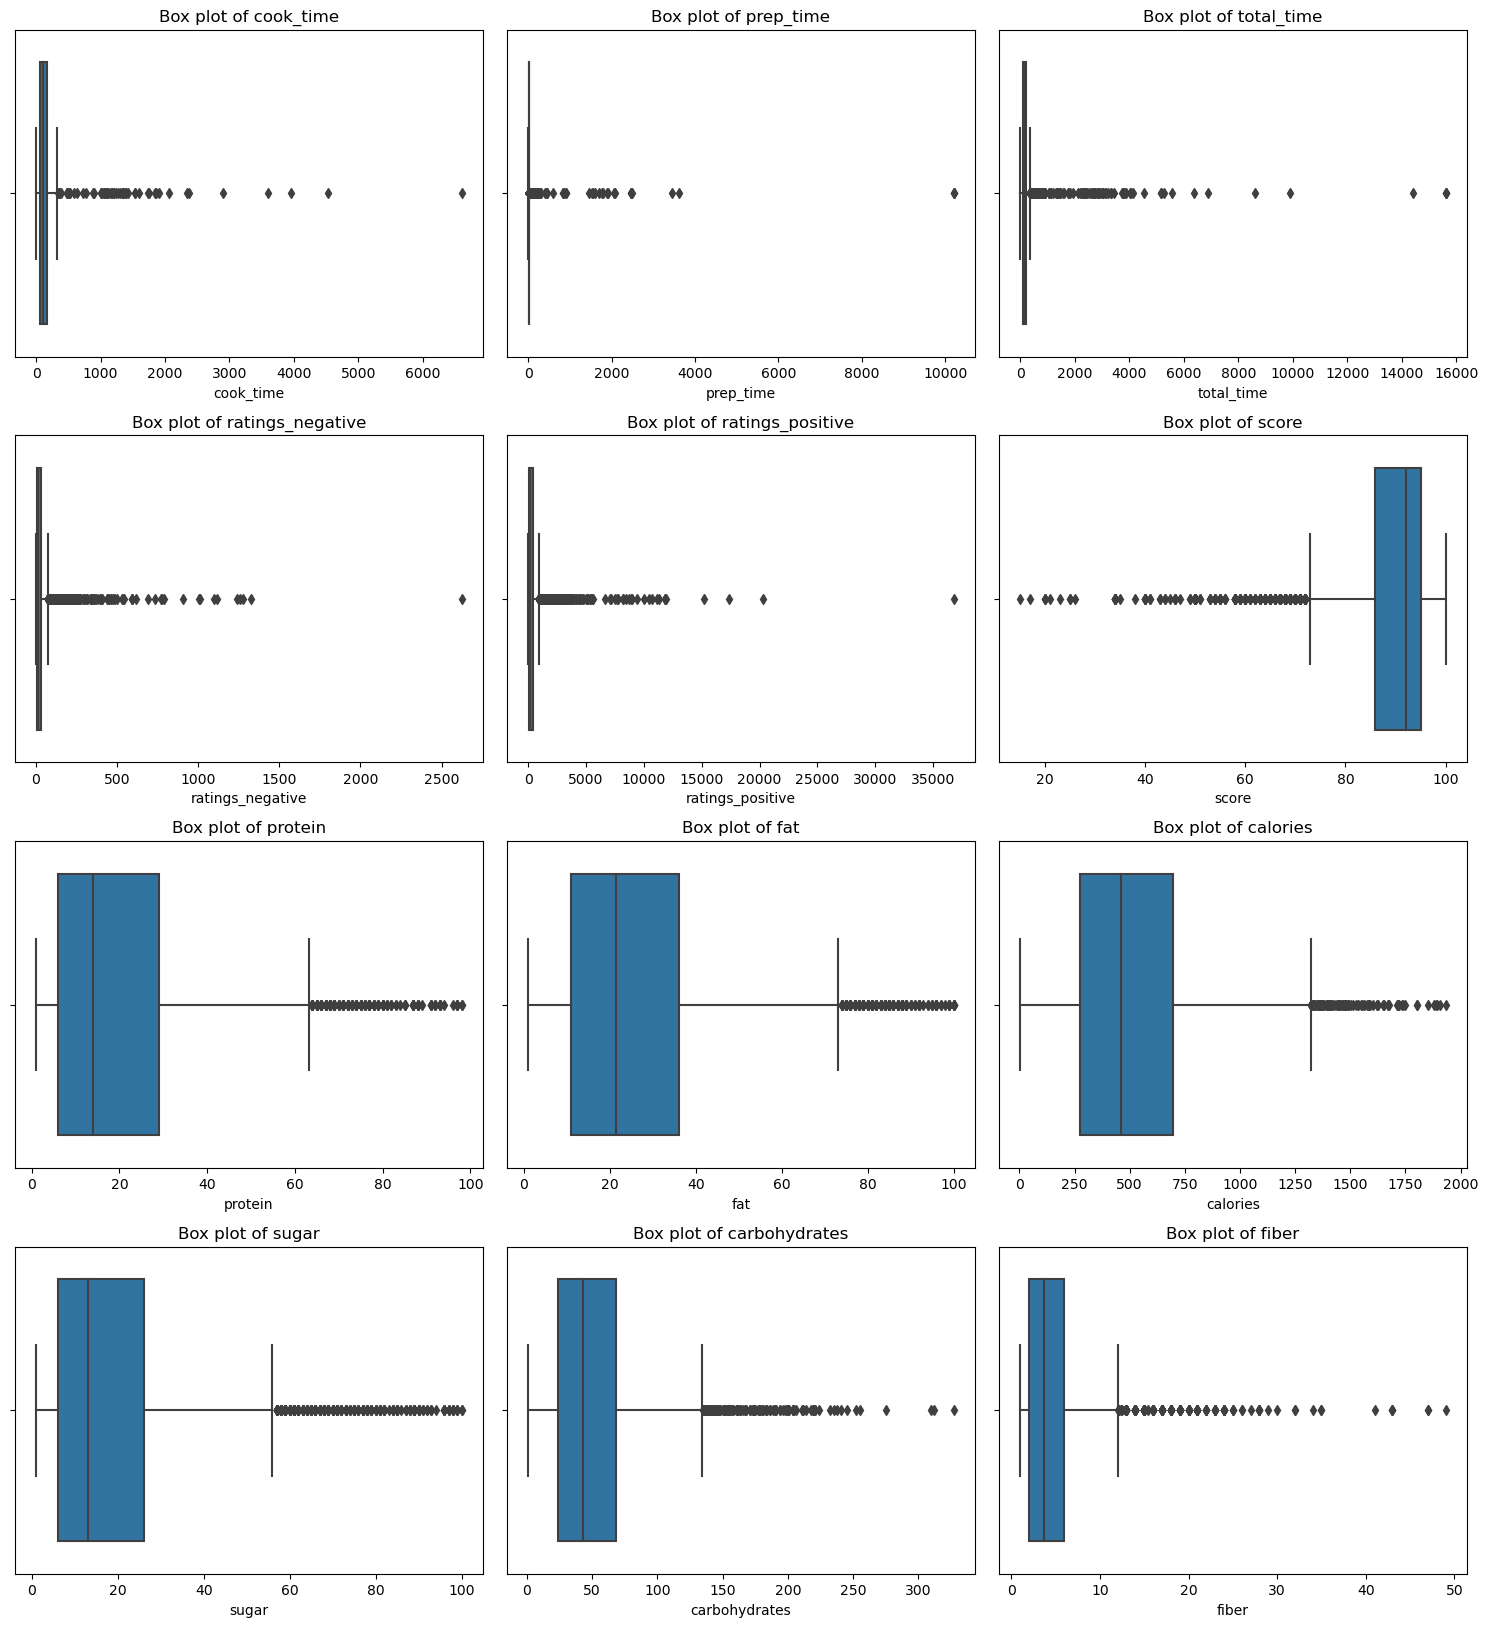

In [18]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

# Create box plots for each selected column
for i, col in enumerate(selected_columns, 1):
    plt.subplot(len(selected_columns) // 3 + 1, 3, i)
    sns.boxplot(x=df_selected[col])
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

In [19]:
# Identify and handle outliers using IQR method for all numeric columns
def cap_outliers(df, cols, threshold=1.5):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df


# Cap outliers in the selected columns
df_numerical = cap_outliers(df_numerical, selected_columns)

# Verify the changes
df_numerical[selected_columns].describe()

,cook_time,prep_time,total_time,ratings_negative,ratings_positive,score,protein,fat,calories,sugar,carbohydrates,fiber
count,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.000000,4961.00000,4961.000000,4961.000000
mean,116.287551,14.031193,150.864225,23.034320,271.230705,89.799256,19.518971,25.638696,510.182333,18.19173,49.731490,4.399964
std,68.354743,5.513968,72.407380,22.297772,296.428010,7.470504,17.092887,18.848206,301.645397,15.74808,33.339695,3.098951
min,1.000000,1.000000,2.000000,1.000000,1.000000,72.500000,1.000000,1.000000,3.000000,1.00000,1.000000,1.000000
25%,63.814160,10.311179,100.146140,6.000000,44.000000,86.000000,6.000000,11.000000,275.000000,6.00000,24.000000,2.000000
50%,111.629104,11.744748,149.961729,15.000000,147.000000,92.000000,14.000000,21.529919,461.000000,13.00000,43.000000,3.652675
75%,168.683986,16.544646,199.255879,33.000000,401.000000,95.000000,29.000000,36.000000,694.000000,26.00000,68.000000,6.000000
max,325.988724,25.894847,347.920486,73.500000,936.500000,100.000000,63.500000,73.500000,1322.500000,56.00000,134.000000,12.000000


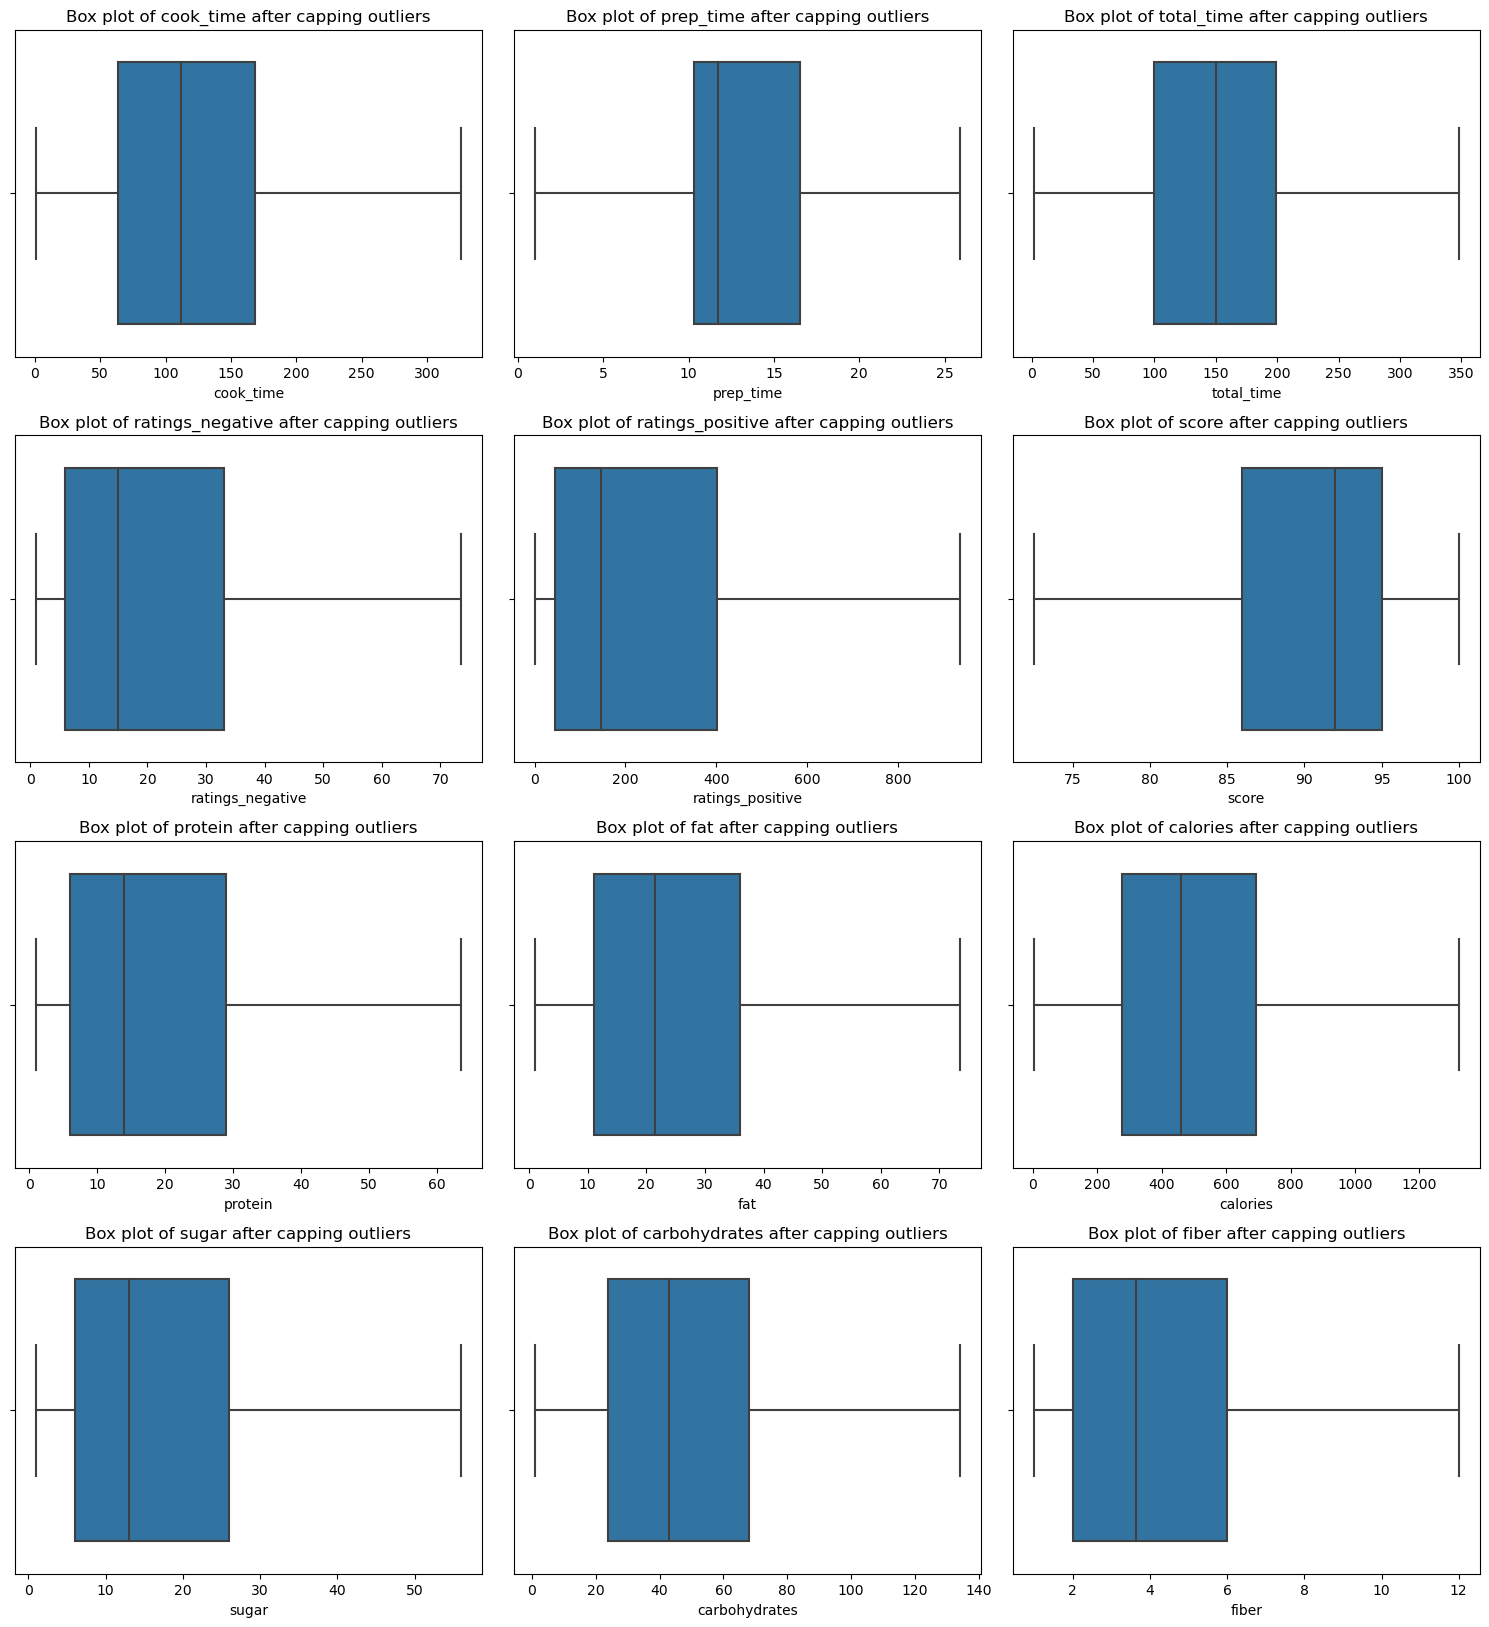

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

# Create box plots for each selected column after capping outliers
for i, col in enumerate(selected_columns, 1):
    plt.subplot(len(selected_columns) // 3 + 1, 3, i)
    sns.boxplot(x=df_numerical[col])
    plt.title(f'Box plot of {col} after capping outliers')

plt.tight_layout()
plt.show()

The box plots show that the outliers have been effectively capped, resulting in more compact and controlled distributions for each column. The data is now better prepared for model training.

### Standardize data

Now that the outliers have been handled, the next step is to standardize the numerical features. This will ensure that all features contribute equally to the model training process.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
# List of columns to standardize (excluding vectorized text features)
columns_to_standardize = [
    'cook_time', 'prep_time', 'total_time', 'score','ratings_negative', 'ratings_positive',
    'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps'
]

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize only the selected columns
df_numerical[columns_to_standardize] = scaler.fit_transform(df_numerical[columns_to_standardize])

# Verify standardization
print(df_numerical[columns_to_standardize].describe())

          cook_time     prep_time    total_time         score  \
count  4.961000e+03  4.961000e+03  4.961000e+03  4.961000e+03   
mean  -1.088515e-16 -1.203096e-16 -1.059870e-16 -4.010320e-16   
std    1.000101e+00  1.000101e+00  1.000101e+00  1.000101e+00   
min   -1.686776e+00 -2.363544e+00 -2.056133e+00 -2.315908e+00   
25%   -7.677401e-01 -6.747209e-01 -7.005252e-01 -5.086188e-01   
50%   -6.815791e-02 -4.147061e-01 -1.246539e-02  2.946208e-01   
75%    7.666142e-01  4.558797e-01  6.683923e-01  6.962406e-01   
max    3.068146e+00  2.151781e+00  2.721768e+00  1.365607e+00   

       ratings_negative  ratings_positive       protein           fat  \
count      4.961000e+03      4.961000e+03  4.961000e+03  4.961000e+03   
mean      -5.729028e-17      4.583223e-17 -1.374967e-16 -2.291611e-17   
std        1.000101e+00      1.000101e+00  1.000101e+00  1.000101e+00   
min       -9.882844e-01     -9.117153e-01 -1.083541e+00 -1.307349e+00   
25%       -7.640242e-01     -7.666401e-01 -7.9099

The summary statistics show that the numerical columns have been successfully standardized, with means close to 0 and standard deviations close to 1. This is expected after applying the StandardScaler.

## 4. Baseline model

### Feature selection

In [24]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df_numerical, test_size=0.2, random_state=42)

In [25]:
# Segment the training and testing sets into user-generated and publisher-curated subsets
train_publisher = train_df[train_df['is_community'] == 0]
train_user = train_df[train_df['is_community'] == 1]
test_publisher = test_df[test_df['is_community'] == 0]
test_user = test_df[test_df['is_community'] == 1]

In [26]:
# Perform feature selection on the training subsets
def select_top_features(train_data, target='score', top_n=20):
    correlation_with_target = train_data.corr()[target].sort_values(ascending=False)
    top_features = correlation_with_target.abs().sort_values(ascending=False).head(top_n + 1).index.tolist()
    top_features.remove(target)
    return top_features

In [27]:
top_features_publisher = select_top_features(train_publisher)
top_features_user = select_top_features(train_user)

In [28]:
# Retrieve feature names
name_feature_names = vectorizers['name'].get_feature_names_out()
ingredients_feature_names = vectorizers['flattened_ingredients'].get_feature_names_out()
instructions_feature_names = vectorizers['flattened_instructions'].get_feature_names_out()
keywords_feature_names = vectorizers['keywords'].get_feature_names_out()

In [29]:
# Function to map TF-IDF feature indices to actual terms
def map_tfidf_features(feature_names, prefix):
    return {f'{prefix}{i}': term for i, term in enumerate(feature_names)}

name_prefix = 'name_tfidf_'
ingredients_prefix = 'flattened_ingredients_tfidf_'
instructions_prefix = 'flattened_instructions_tfidf_'
keywords_prefix = 'keywords_tfidf_'

In [30]:
# Map TF-IDF features to terms
name_tfidf_features = map_tfidf_features(name_feature_names, name_prefix)
ingredients_tfidf_features = map_tfidf_features(ingredients_feature_names, ingredients_prefix)
instructions_tfidf_features = map_tfidf_features(instructions_feature_names, instructions_prefix)
keywords_tfidf_features = map_tfidf_features(keywords_feature_names, keywords_prefix)

In [31]:
# Combine all mappings into a single dictionary
tfidf_mappings = {**name_tfidf_features, **ingredients_tfidf_features, **instructions_tfidf_features, **keywords_tfidf_features}

In [32]:
# Function to rename features with actual terms
def rename_features(features, mappings):
    return [mappings.get(feature, feature) for feature in features]

# Rename top features with actual terms
top_features_publisher_renamed = rename_features(top_features_publisher, tfidf_mappings)
top_features_user_renamed = rename_features(top_features_user, tfidf_mappings)

### Model training and evaluation

In [33]:
# Prepare training and testing sets with selected features
X_train_publisher = train_publisher[top_features_publisher]
y_train_publisher = train_publisher['score']
X_test_publisher = test_publisher[top_features_publisher]
y_test_publisher = test_publisher['score']
X_train_user = train_user[top_features_user]
y_train_user = train_user['score']
X_test_user = test_user[top_features_user]
y_test_user = test_user['score']

In [34]:
# Train a Random Forest Regressor for publisher-curated recipes
rf_publisher = RandomForestRegressor(n_estimators=100, random_state=42)
rf_publisher.fit(X_train_publisher, y_train_publisher)

# Train a Random Forest Regressor for user-generated recipes
rf_user = RandomForestRegressor(n_estimators=100, random_state=42)
rf_user.fit(X_train_user, y_train_user)

RandomForestRegressor(random_state=42)

In [35]:
# Make predictions on the test sets
y_pred_publisher = rf_publisher.predict(X_test_publisher)
y_pred_user = rf_user.predict(X_test_user)

In [36]:
# Evaluate the models
mse_publisher = mean_squared_error(y_test_publisher, y_pred_publisher)
r2_publisher = r2_score(y_test_publisher, y_pred_publisher)
mse_user = mean_squared_error(y_test_user, y_pred_user)
r2_user = r2_score(y_test_user, y_pred_user)

print(f"Publisher-Curated Recipes - MSE: {mse_publisher}, R^2: {r2_publisher}")
print(f"User-Generated Recipes - MSE: {mse_user}, R^2: {r2_user}")

Publisher-Curated Recipes - MSE: 0.7012483026694918, R^2: 0.2504156535789629
User-Generated Recipes - MSE: 1.2036394290936165, R^2: 0.3678251342176323


**Publisher-Curated Recipes:** The model has a moderate level of accuracy with an MSE of 0.701 and an R^2 of 0.250. This suggests that the model is able to capture some of the patterns in the data but still leaves a substantial amount of variance unexplained.

**User-Generated Recipes:** The model performs relatively better for user-generated recipes with an MSE of 1.204 and an R^2 of 0.368. While the MSE is higher, indicating larger errors in prediction, the higher R^2 suggests that the model explains a larger proportion of the variance compared to publisher-curated recipes.

**Further improvements** could involve enhancing feature engineering, trying different modeling approaches, or performing more extensive hyperparameter tuning to improve the predictive power for both subsets of data.

In [37]:
# Plotting feature importances for both models
def plot_feature_importances(model, features, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(7, 5))
    plt.title(title)
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

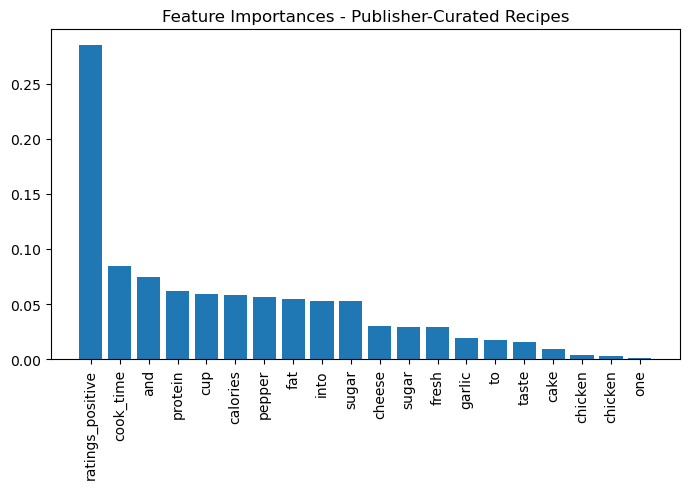

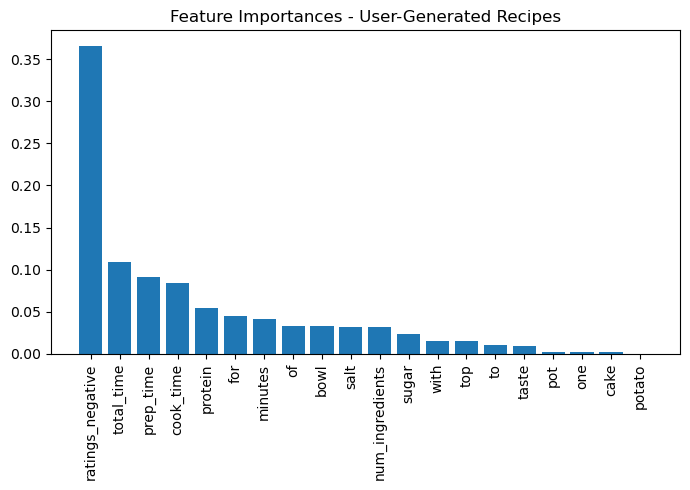

In [38]:
plot_feature_importances(rf_publisher, top_features_publisher_renamed, "Feature Importances - Publisher-Curated Recipes")
plot_feature_importances(rf_user, top_features_user_renamed, "Feature Importances - User-Generated Recipes")

## 5. Advanced model

In [39]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset

In [40]:
# Select the text columns from df_merge
text_columns = df_merge[['keywords', 'name', 'flattened_ingredients', 'flattened_instructions']]

# Select the numerical columns from df_numerical
numerical_columns = df_numerical[['cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive', 'score', 'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps']]

# Concatenate the text and numerical columns
df_combined = pd.concat([text_columns, numerical_columns], axis=1)

In [41]:
df_combined

,keywords,name,flattened_ingredients,flattened_instructions,cook_time,prep_time,total_time,ratings_negative,ratings_positive,score,protein,fat,calories,sugar,carbohydrates,fiber,num_ingredients,num_steps
0,"bake sale, breakfast, cinnamon buns, cinnamon rolls, dessert, frosting, homemade, recipe, tasty, tasty_vegetarian, today food, video, yeast",Homemade Cinnamon Rolls,½ cup unsalted butter melted; 2 cups whole milk warm to the touch; ½ cup granulated sugar; 2 ¼ teaspoons active dry yeast; 5 cups flour divided; 1 teaspoon baking powder; 2 teaspoons salt; ¾ cup butter softened; ¾ cup light brown sugar; 2 tablespoons ground cinnamon; 4 oz cream cheese softened; 2 tablespoons butter melted; 2 tablespoons whole milk; 1 teaspoon vanilla extract; 1 cup powdered sugar,"Generously butter two disposable foil pie/cake pans. In a large bowl, whisk together warm milk, melted butter, and granulated sugar. The mixture should be just warm, registering between 100-110˚F (37-43˚C). If it is hotter, allow to cool slightly. Sprinkle the yeast evenly over the warm mixture and let set for 1 minute. Add 4 cups (500g) of all-purpose flour to the milk mixture and mix with a wooden spoon until just combined. Cover the bowl with a towel or plastic wrap and set in a warm place to rise for 1 hour. After 1 hour, the dough should have nearly doubled in size. Remove the towel and add an additional ¾ cup (95g) of flour, the baking powder, and salt. Stir well, then turn out onto a well-floured surface. Knead the dough lightly, adding additional flour as necessary, until the dough just loses its stickiness and does not stick to the surface. Roll the dough out into a large rectangle, about ½-inch (1 cm) thick. Fix corners to make sure they are sharp and even. Spread the softened butter evenly over the dough. Sprinkle evenly with brown sugar and a generous sprinkling of cinnamon. Press the mixture into the butter. Roll up the dough, forming a log, and pinch the seam closed. Place seam-side down. Trim off any unevenness on either end. Cut the log in half, then divide each half into 7 evenly sized pieces. About 1½ inches (8cm) thick each. Place 7 cinnamon rolls in each cake pan, one in the center, six around the sides. Cover with plastic wrap and place in a warm place to rise for 30 minutes. Preheat oven to 350˚F (180˚C). To prepare the frosting. In a medium-size mixing bowl, whisk together cream cheese, butter, whole milk, vanilla, and powdered sugar, until smooth. Remove plastic wrap. Bake the cinnamon rolls in a preheated oven for 25-30 minutes, until golden brown. While still warm, drizzle evenly with frosting. Enjoy!",-1.262476,2.151781,0.001875,2.263489,2.244512,1.097860,-0.732482,-0.246133,-0.103385,0.368861,0.398019,-1.097244,0.550026,2.989973
1,"1000 whisk omelette, 3 ingredient mac & cheese, 3 ingredient recipes, 3-ingredient coffee, 400 whisk coffee, creme brulee, dalgona coffee, day in the life, fluffy omelette, how to make 3 ingredient recipes, jiggly omelette, korean coffee, tasty 3 ingredient recipes, tasty alvin, tasty vlog, teriyaki chicken, whipped coffee",Whipped Coffee,2 tablespoons hot water; 2 tablespoons sugar; 2 tablespoons instant coffee powder; milk to serve; ice to serve,"Add the hot water, sugar, and instant coffee to a bowl. Either hand whisk or use an electric mixer until the mixture is fluffy and light. To serve, spoon a dollop over a cup of milk with ice in it and stir. Enjoy!",-1.244249,0.175718,-1.876576,2.263489,2.244512,0.294621,-1.076851,-1.165699,-1.462733,-0.012176,-0.951859,-0.707417,-1.112079,-1.230915
2,"dome pancakes, easy pancakes, japanese fluffy pancakes, japanese pancakes, no flip pancakes, pancake perfection, pancakes, rice cooker pancakes, round pancakes, smooth pancakes, tasty, tasty_vegetarian",Fluffy Pancakes,4 cups flour sifted; 4 tablespoons baking powder; 4 cups milk warm to the touch; ¾ cup butter melted; 3 egg yolks; 4 egg whites; maple syrup to serve,"Whisk together the flour and baking powder in a large bo

In [71]:
# Segment the data into user-generated and publisher-curated recipes
user_generated = df_combined[df_combined['is_community'] == 1]
publisher_curated = df_combined[df_combined['is_community'] == 0]

In [72]:
# Function to perform feature selection
def feature_selection(df):
    X = df.drop(columns=['score'])
    y = df['score']
    selector = SelectKBest(f_regression, k='all')
    selector.fit(X, y)
    cols = selector.get_support(indices=True)
    selected_features = X.columns[cols]
    return selected_features

In [73]:
# Split and perform feature selection for user-generated recipes
train_user_df, test_user_df = train_test_split(user_generated, test_size=0.2, random_state=42)
selected_features_user = feature_selection(train_user_df[numerical_columns])
train_user_df = pd.concat([train_user_df[selected_features_user], train_user_df[text_columns.columns], train_user_df['score']], axis=1)
test_user_df = pd.concat([test_user_df[selected_features_user], test_user_df[text_columns.columns], test_user_df['score']], axis=1)

# Split and perform feature selection for publisher-curated recipes
train_pub_df, test_pub_df = train_test_split(publisher_curated, test_size=0.2, random_state=42)
selected_features_pub = feature_selection(train_pub_df[numerical_columns])
train_pub_df = pd.concat([train_pub_df[selected_features_pub], train_pub_df[text_columns.columns], train_pub_df['score']], axis=1)
test_pub_df = pd.concat([test_pub_df[selected_features_pub], test_pub_df[text_columns.columns], test_pub_df['score']], axis=1)

In [74]:
# Define a custom dataset class
class RecipeDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = " ".join([str(row['keywords']), str(row['name']), str(row['flattened_ingredients']), str(row['flattened_instructions'])])
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        numerical_features = torch.tensor(row[selected_features_user].values.astype(float), dtype=torch.float32)
        label = torch.tensor(row['score'], dtype=torch.float32)
        return inputs, numerical_features, label

In [75]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [76]:
# Create DataLoader instances for user-generated recipes
train_user_dataset = RecipeDataset(train_user_df, tokenizer, max_length=512)
test_user_dataset = RecipeDataset(test_user_df, tokenizer, max_length=512)
train_user_loader = DataLoader(train_user_dataset, batch_size=8, shuffle=True)
test_user_loader = DataLoader(test_user_dataset, batch_size=8, shuffle=False)

In [77]:
# Create DataLoader instances for publisher-curated recipes
train_pub_dataset = RecipeDataset(train_pub_df, tokenizer, max_length=512)
test_pub_dataset = RecipeDataset(test_pub_df, tokenizer, max_length=512)
train_pub_loader = DataLoader(train_pub_dataset, batch_size=8, shuffle=True)
test_pub_loader = DataLoader(test_pub_dataset, batch_size=8, shuffle=False)

In [78]:
# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self, bert_model, numerical_feature_size):
        super(CombinedModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768 + numerical_feature_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, numerical_features):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_output.last_hidden_state[:, 0, :]  # CLS token
        combined_input = torch.cat((cls_output, numerical_features), dim=1)
        x = self.dropout(combined_input)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [79]:
# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [80]:
def train_and_evaluate(model, train_loader, test_loader):
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.MSELoss()

    # Function to train the model for one epoch
    def train_epoch(model, dataloader, optimizer, criterion, device):
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs, numerical_features, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            numerical_features = numerical_features.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs['input_ids'], inputs['attention_mask'], numerical_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    # Function to evaluate the model
    def evaluate(model, dataloader, device):
        model.eval()
        predictions, true_labels = []
        with torch.no_grad():
            for batch in dataloader:
                inputs, numerical_features, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                numerical_features = numerical_features.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(inputs['input_ids'], inputs['attention_mask'], numerical_features)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        return predictions, true_labels

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}")

    # Evaluation
    predictions, true_labels = evaluate(model, test_loader, device)
    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    print(f"Test MSE: {mse}, Test R^2: {r2}")

In [81]:
# Training and evaluating the model for user-generated recipes
model_user = CombinedModel(bert_model, numerical_feature_size=train_user_df[['cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive', 'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps']].shape[1]).to(device)
train_and_evaluate(model_user, train_user_loader, test_user_loader)

KeyboardInterrupt: 

In [ ]:
# Training and evaluating the model for publisher-curated recipes
model_pub = CombinedModel(bert_model, numerical_feature_size=train_pub_df[['cook_time', 'prep_time', 'total_time', 'ratings_negative', 'ratings_positive', 'protein', 'fat', 'calories', 'sugar', 'carbohydrates', 'fiber', 'num_ingredients', 'num_steps']].shape[1]).to(device)
train_and_evaluate(model_pub, train_pub_loader, test_pub_loader)